In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataset_url = 'https://www.kaggle.com/bingazuran/nsfwsfwdataset2'

In [ ]:
!pip install jovian opendatasets --upgrade --quiet
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in "./nsfwsfwdataset2" (use force=True to force download)


In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
data_dir = '/content/nsfwsfwdataset2/NSFW-FSW-Dataset-Omar-3'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['nsfw', 'sfw']


In [ ]:
#import os

#file_path = './nsfwsfwdataset/bug-omar-dataset/train/sfw/4bb193d3-edfa-4e0d-9ff6-36fc859de90a.jpg'
#os.remove(file_path)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
trainset = ImageFolder(data_dir+'/train', transform=transform_train)
testset = ImageFolder(data_dir+'/test', transform=transform_test)

In [ ]:
trainset

Dataset ImageFolder
    Number of datapoints: 5000
    Root location: /content/nsfwsfwdataset2/NSFW-FSW-Dataset-Omar-3/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
batch_size = 16
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
img, label = trainset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[ 0.7569,  0.7569,  0.7490,  ...,  0.6706,  0.6627,  0.6627],
         [ 0.7569,  0.7569,  0.7490,  ...,  0.6706,  0.6627,  0.6627],
         [ 0.7647,  0.7647,  0.7490,  ...,  0.6627,  0.6549,  0.6549],
         ...,
         [ 0.2157,  0.2157,  0.2235,  ...,  0.4745,  0.4980,  0.5059],
         [ 0.2078,  0.2078,  0.2157,  ...,  0.4588,  0.4745,  0.4824],
         [ 0.2078,  0.2078,  0.2157,  ...,  0.4510,  0.4667,  0.4667]],

        [[ 0.1373,  0.1373,  0.1294,  ...,  0.0588,  0.0510,  0.0431],
         [ 0.1373,  0.1373,  0.1294,  ...,  0.0588,  0.0431,  0.0353],
         [ 0.1451,  0.1451,  0.1294,  ...,  0.0510,  0.0353,  0.0275],
         ...,
         [-0.3333, -0.3255, -0.3176,  ..., -0.0902, -0.0667, -0.0510],
         [-0.3490, -0.3412, -0.3333,  ..., -0.0980, -0.0902, -0.0902],
         [-0.3569, -0.3490, -0.3412,  ..., -0.1059, -0.1059, -0.1059]],

        [[-0.1843, -0.1843, -0.1765,  ..., -0.1765, -0.1843, -0.1922],
         [-0.1843, -0.1843, -0.1765,  ..., -0

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision import models
batch_size = 16

In [ ]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 4096])
torch.Size([2])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
loss_epoch_arr = []
max_epochs = 5
train_accuracy = []
test_accuracy = []

n_iters = np.ceil(5000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

    train_a = evaluation(trainloader, vgg)
    test_a = evaluation(testloader, vgg)
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, test_a, train_a))
    train_accuracy.append(train_a)
    test_accuracy.append(test_a)
    
    


Iteration: 0/313, Loss: 0.70
Iteration: 100/313, Loss: 0.03
Iteration: 200/313, Loss: 1.11
Iteration: 300/313, Loss: 0.73
Epoch: 0/5, Test acc: 85.20, Train acc: 86.90
Iteration: 0/313, Loss: 0.06
Iteration: 100/313, Loss: 0.32
Iteration: 200/313, Loss: 0.62
Iteration: 300/313, Loss: 0.43
Epoch: 1/5, Test acc: 72.30, Train acc: 73.26
Iteration: 0/313, Loss: 1.41
Iteration: 100/313, Loss: 0.30
Iteration: 200/313, Loss: 1.22
Iteration: 300/313, Loss: 0.73
Epoch: 2/5, Test acc: 87.20, Train acc: 87.14
Iteration: 0/313, Loss: 0.39
Iteration: 100/313, Loss: 0.20
Iteration: 200/313, Loss: 0.63
Iteration: 300/313, Loss: 0.68
Epoch: 3/5, Test acc: 83.00, Train acc: 82.70
Iteration: 0/313, Loss: 2.11
Iteration: 100/313, Loss: 0.12
Iteration: 200/313, Loss: 1.51
Iteration: 300/313, Loss: 0.45
Epoch: 4/5, Test acc: 85.50, Train acc: 85.18


No handles with labels found to put in legend.


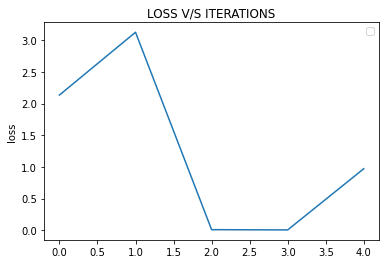

In [ ]:
plt.plot(loss_epoch_arr)
plt.ylabel('loss')
plt.title("LOSS V/S ITERATIONS")
plt.legend()
plt.show()